In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset= tf.keras.utils.image_dataset_from_directory(
    "corn",
    batch_size=BATCH_SIZE,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    shuffle=True,
)

Found 8031 files belonging to 4 classes.


In [4]:
class_names= dataset.class_names
class_names

['Corn___Common_Rust',
 'Corn___Gray_Leaf_Spot',
 'Corn___Healthy',
 'Corn___Northern_Leaf_Blight']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[2 0 2 3 3 2 3 0 2 2 3 3 2 2 3 2 0 3 1 2 0 3 2 2 3 3 3 0 3 0 2 3]


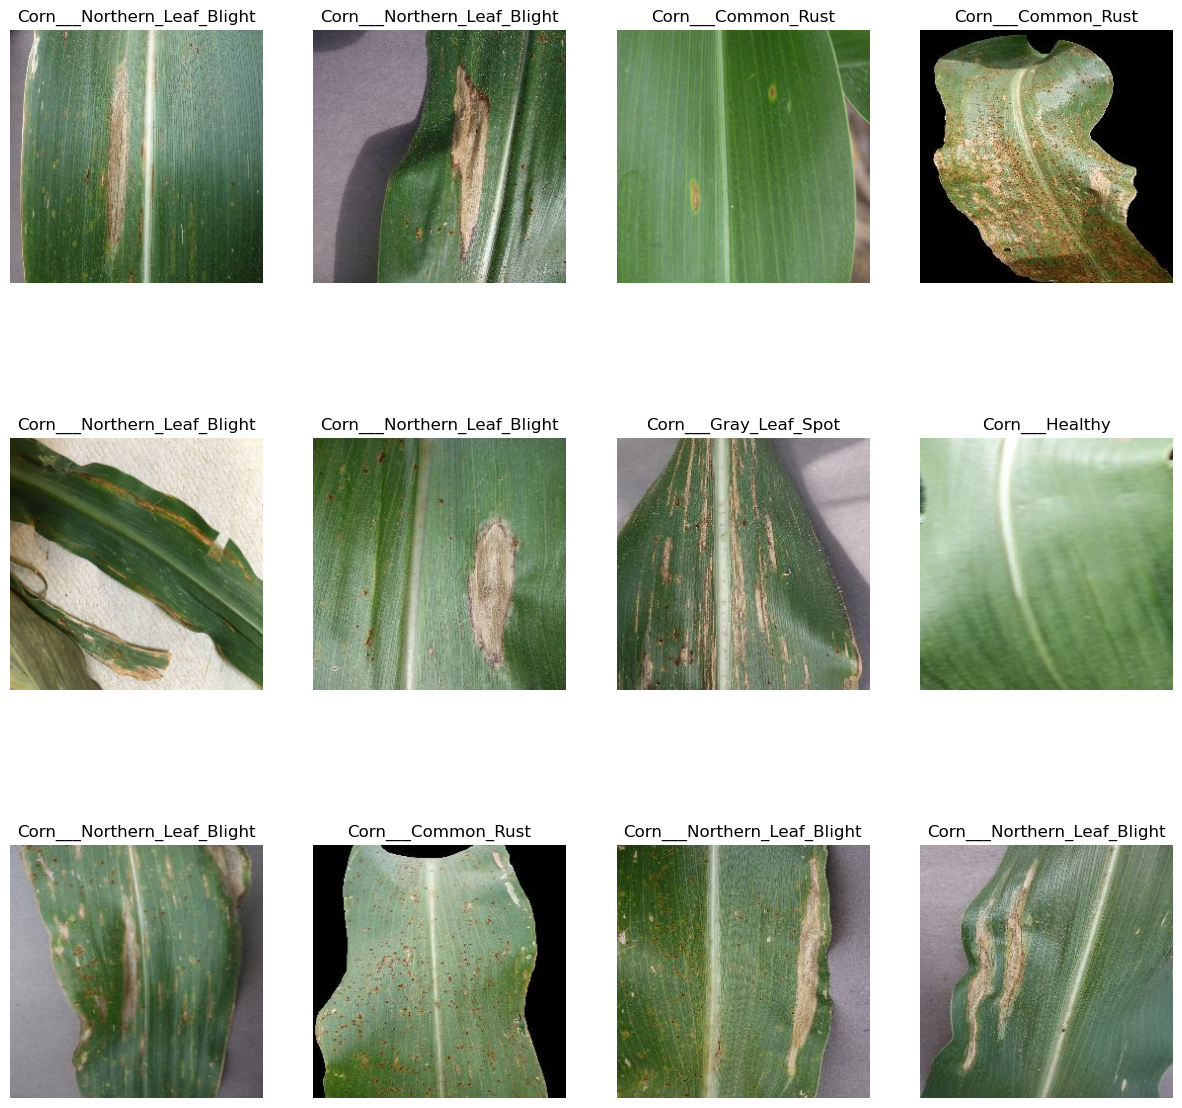

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

251

# Function to Split Dataset
80% for training
20% == 10% validation, 10% test

In [8]:
train_size = 0.8
len(dataset)*train_size

200.8

In [9]:
train_ds = dataset.take(200)
len(train_ds)

200

In [10]:
test_ds = dataset.skip(200)
len(test_ds)

51

In [11]:
val_size=0.1
len(dataset)*val_size

25.1

In [12]:
val_ds = test_ds.take(25)
len(val_ds)

25

In [13]:
test_ds = test_ds.skip(25)
len(test_ds)

26

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

200

In [17]:
len(val_ds)

25

In [18]:
len(test_ds)

26

# Cache, Shuffle, and Prefetch

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation

In [21]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4
model = keras.Sequential([
    # Resize and rescale layer
    layers.experimental.preprocessing.Rescaling(1.0 / 255, input_shape=input_shape[1:]),

    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

# Build the model with the updated input shape
model.build(input_shape=input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)       

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
200/200 [==============================] - 217s 994ms/step - loss: 0.5280 - accuracy: 0.7770 - val_loss: 0.3437 - val_accuracy: 0.8650
Epoch 2/50
200/200 [==============================] - 178s 888ms/step - loss: 0.3247 - accuracy: 0.8687 - val_loss: 0.3253 - val_accuracy: 0.8625
Epoch 3/50
200/200 [==============================] - 187s 933ms/step - loss: 0.3357 - accuracy: 0.8736 - val_loss: 0.2670 - val_accuracy: 0.8700
Epoch 4/50
200/200 [==============================] - 179s 896ms/step - loss: 0.2727 - accuracy: 0.8936 - val_loss: 0.2486 - val_accuracy: 0.8988
Epoch 5/50
200/200 [==============================] - 179s 892ms/step - loss: 0.2407 - accuracy: 0.9069 - val_loss: 0.2239 - val_accuracy: 0.8988
Epoch 6/50
200/200 [==============================] - 183s 913ms/step - loss: 0.2447 - accuracy: 0.9076 - val_loss: 0.1836 - val_accuracy: 0.9312
Epoch 7/50
200/200 [==============================] - 189s 943ms/step - loss: 0.2272 - accuracy: 0.9136 - val_loss: 0.1891 -

In [27]:
scores = model.evaluate(test_ds)

26/26 [==============================] - 26s 198ms/step - loss: 0.1222 - accuracy: 0.9543


In [28]:
scores

[0.12224820256233215, 0.9543269276618958]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 200}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
type(history.history['loss'])

list

In [33]:
len(history.history['loss'])

50

In [34]:
history.history['loss'][:5]

[0.5280413031578064,
 0.32467663288116455,
 0.3357056975364685,
 0.2726767063140869,
 0.240748792886734]

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

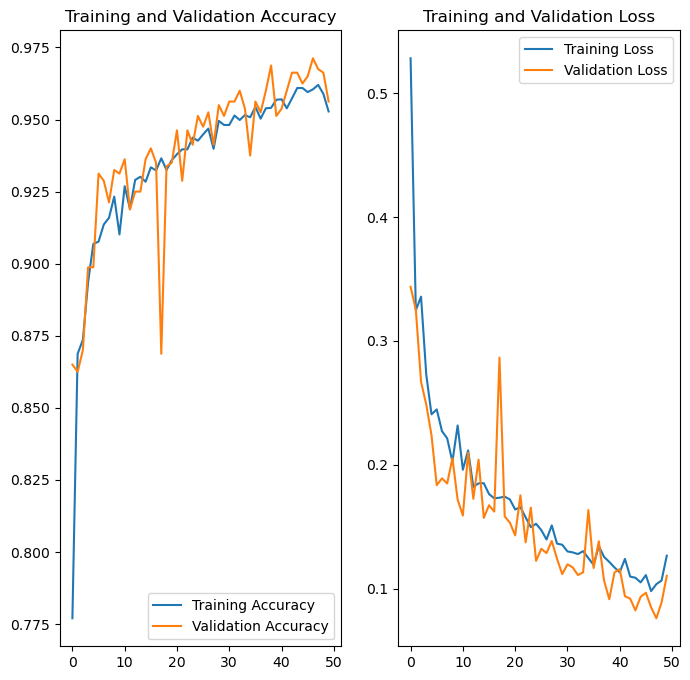

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Corn___Common_Rust
1/1 [==============================] - 0s 444ms/step
predicted label: Corn___Common_Rust


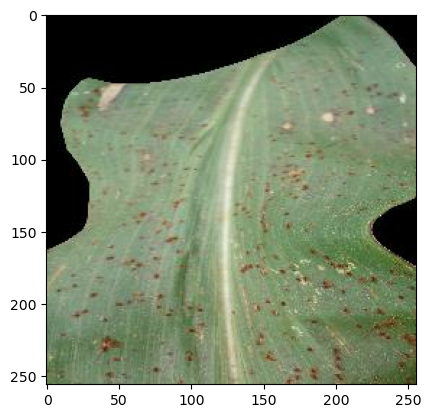

In [37]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 36ms/step


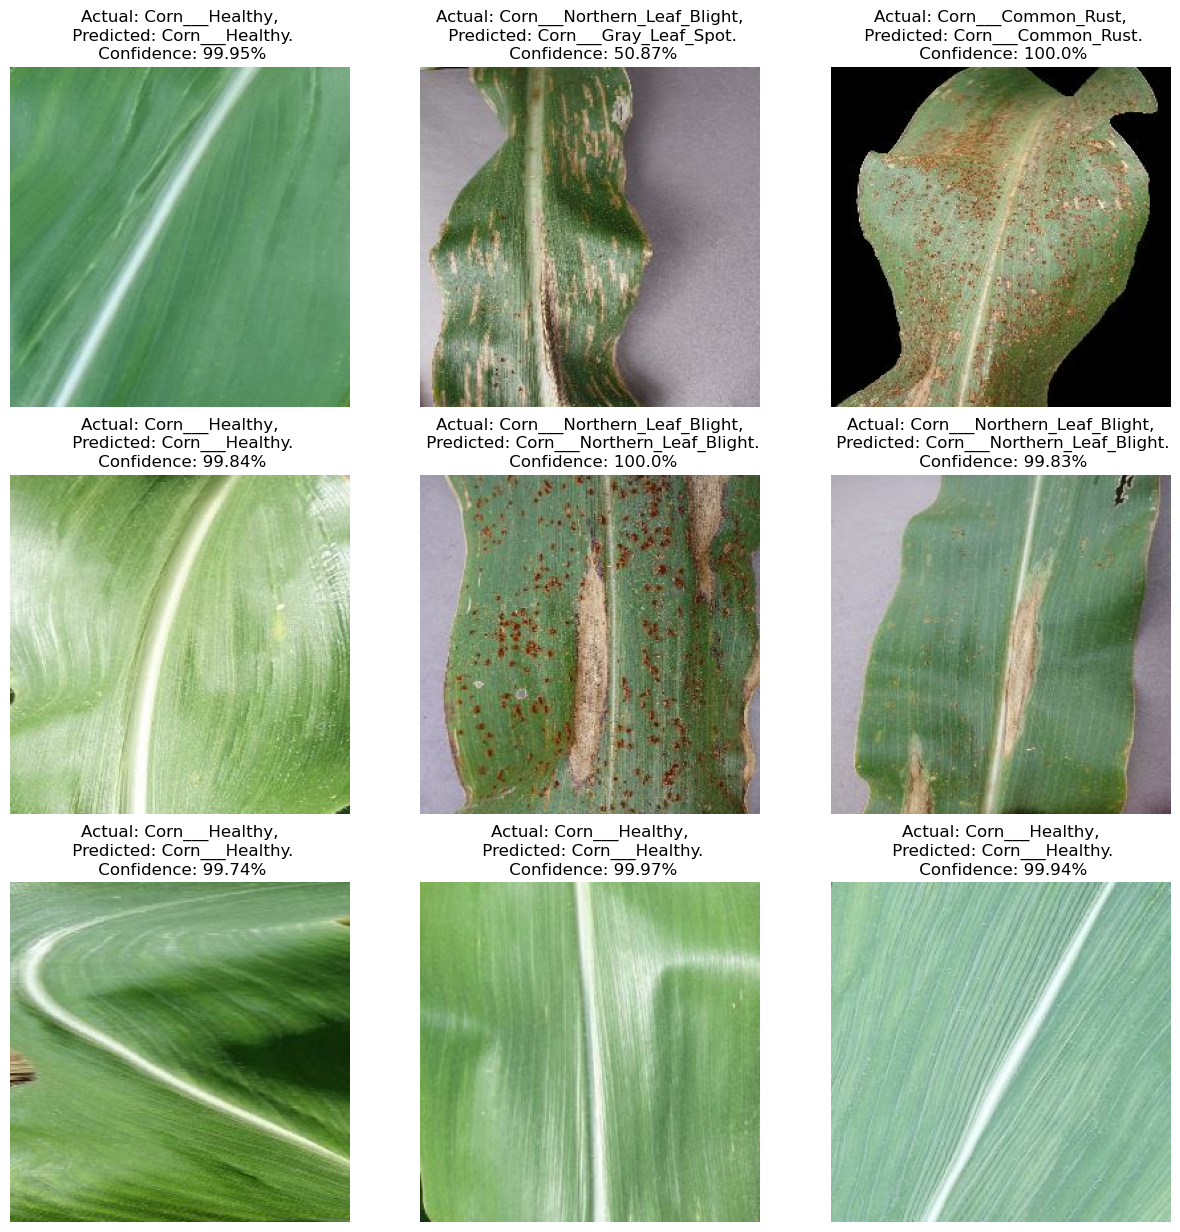

In [39]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

1/1 [==============================] - 0s 208ms/step
Accuracy: 0.9543269230769231
F1 Score: 0.954252349529003
Confusion Matrix:
[[256   1   0   1]
 [  1  87   0  14]
 [  0   0 254   1]
 [  5  15   0 197]]

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       258
           1       0.84      0.85      0.85       102
           2       1.00      1.00      1.00       255
           3       0.92      0.91      0.92       217

    accuracy                           0.95       832
   macro avg       0.94      0.94      0.94       832
weighted avg       0.95      0.95      0.95       832



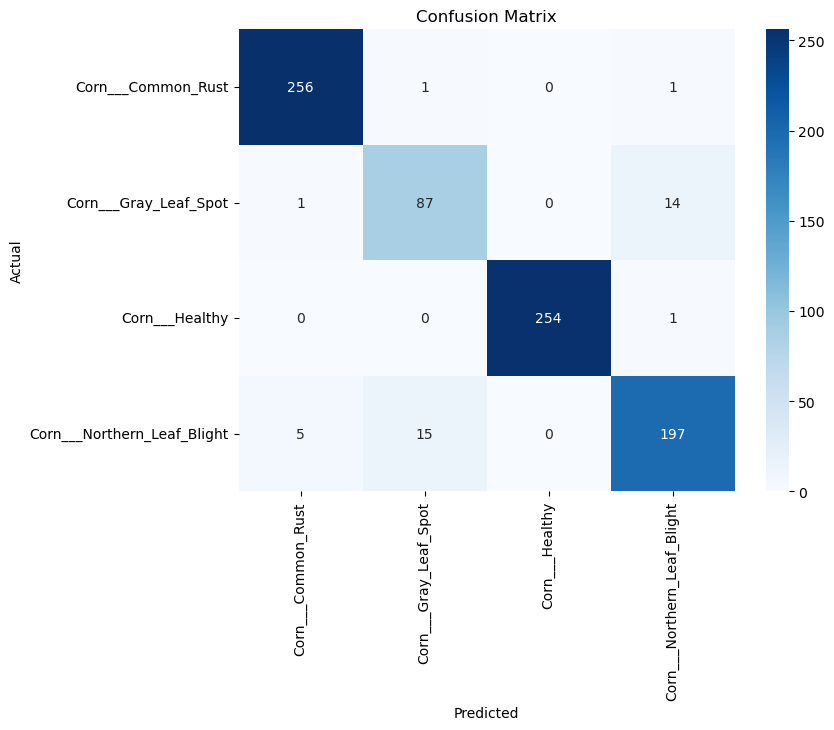

In [58]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tensorflow import keras
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import seaborn as sns
import numpy as np


# Evaluate the model on the test set
scores = model.evaluate(test_ds)

# Get predictions
y_true = []
y_pred = []

for images_batch, labels_batch in test_ds:
    y_true.extend(labels_batch.numpy())
    predictions = model.predict(images_batch)
    y_pred.extend(np.argmax(predictions, axis=1))

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
confusion_mat = confusion_matrix(y_true, y_pred)

# Print metrics
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Confusion Matrix:")
print(confusion_mat)
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ... (your existing code)

1/1 [==============================] - 0s 112ms/step


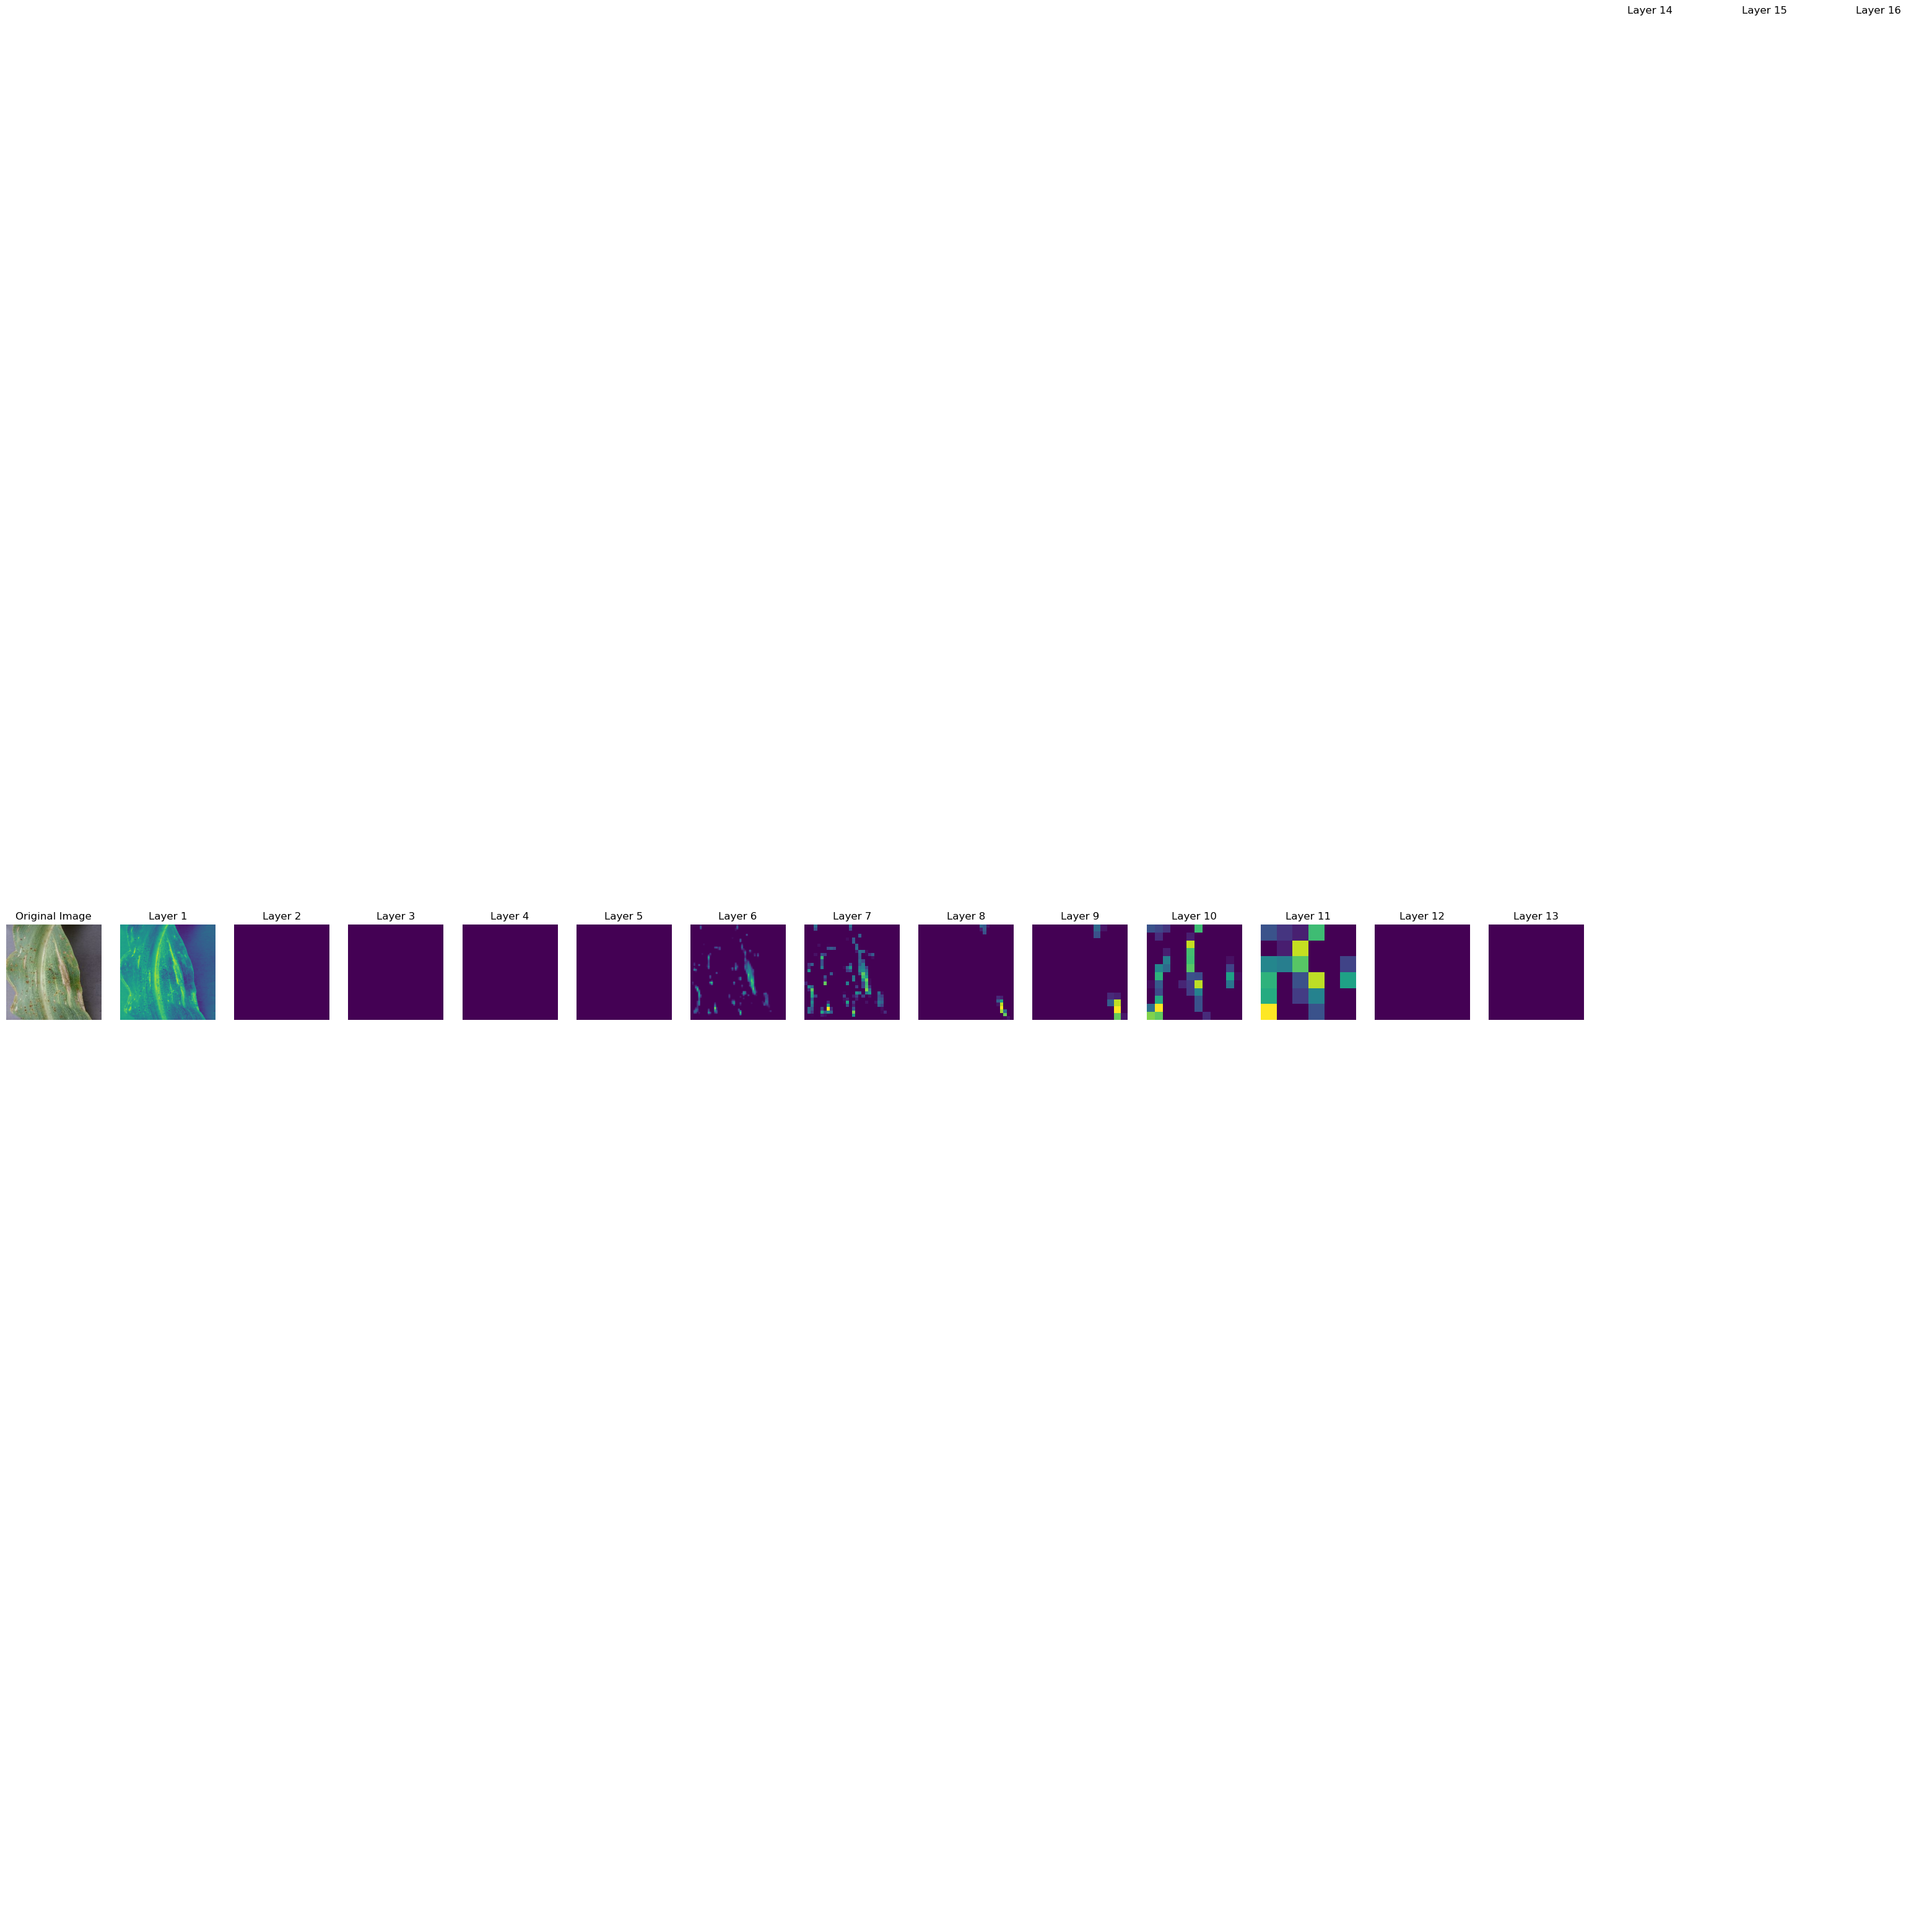

In [79]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import models
from tensorflow.keras.preprocessing.image import img_to_array

# Function to get intermediate layers from the model
def get_intermediate_layers(model, layer_names, img_tensor):
    intermediate_layers_model = models.Model(inputs=model.input, 
                                             outputs=[model.get_layer(layer_name).output for layer_name in layer_names])
    intermediate_layers = intermediate_layers_model.predict(img_tensor)
    return intermediate_layers

# Function to display the original image and intermediate layers
def display_image_and_intermediate_layers(original_image, intermediate_layers):
    num_layers = len(intermediate_layers) + 1
    fig, axes = plt.subplots(1, num_layers, figsize=(40,40))
    
    # Display the original image
    axes[0].imshow(original_image[0].numpy().astype("uint8"))
    axes[0].axis('off')
    axes[0].set_title('Original Image')

    # Display intermediate layers
    for i in range(num_layers - 1):
        layer_data = intermediate_layers[i][0]
        if len(layer_data.shape) == 3:
            axes[i + 1].imshow(layer_data[:, :, 0], cmap='viridis')  
        elif len(layer_data.shape) == 2:
            axes[i + 1].imshow(layer_data, cmap='viridis')
        axes[i + 1].axis('off')
        axes[i + 1].set_title(f'Layer {i + 1}')

    plt.show()

# Choose the correct layer names for visualization based on your model
layer_names_to_visualize = ['rescaling_1', 'conv2d', 'max_pooling2d', 'conv2d_1', 'max_pooling2d_1', 
                            'conv2d_2', 'max_pooling2d_2', 'conv2d_3', 'max_pooling2d_3', 
                            'conv2d_4', 'max_pooling2d_4', 'conv2d_5', 'max_pooling2d_5', 
                            'flatten', 'dense', 'dense_1']

# Take one batch of images from the test dataset for visualization
for images_batch, _ in test_ds.take(1):
    # Choose one image from the batch for visualization
    img_tensor = images_batch[0:1]
    
    # Get intermediate layers
    intermediate_layers = get_intermediate_layers(model, layer_names_to_visualize, img_tensor)
    
    # Display original image and intermediate layers
    display_image_and_intermediate_layers(images_batch, intermediate_layers)


In [80]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/3\assets


INFO:tensorflow:Assets written to: ../models/3\assets


In [81]:
model.save("../corns.h5")
